# Clasificador simple sobre datos estructurados

Nos basaremos el tutorial [Imbalanced classification: credit card fraud detection](https://keras.io/examples/structured_data/imbalanced_classification/), uno de los [ejemplos de Keras sobre datos estructurados](https://keras.io/examples/structured_data/), para utilizar Keras sobre datos de un dominio con el que estamos famirializados.

Utilizaremos el dataset [Kaggle Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud/) para demostrar cómo entrenar un clasificador simple en Keras sobre datos con clases desbalanceadas.


Realizaremos los siguientes pasos:

1. Carga del dataset
2. Preparación del conjunto de validación
4. Análisis del "desbalance" de clases
5. Estandarización (manual) de datos
6. Definición del modelo
7. Entrenamiento del modelo

## 1. Carga de datos

In [ ]:
!mkdir -p ./data
!gdown 1TldKEcayYQDOghWTop67-jOeu05YrRCs -cO ./data/creditcard.csv.zip
!unzip -n ./data/creditcard.csv.zip -d ./data/

Downloading...
From (original): https://drive.google.com/uc?id=1TldKEcayYQDOghWTop67-jOeu05YrRCs
From (redirected): https://drive.google.com/uc?id=1TldKEcayYQDOghWTop67-jOeu05YrRCs&confirm=t&uuid=0cea572a-e756-41ba-acb2-9b3fe2182789
To: /content/data/creditcard.csv.zip
100% 69.2M/69.2M [00:02<00:00, 24.1MB/s]
Archive:  ./data/creditcard.csv.zip
  inflating: ./data/creditcard.csv   


In [ ]:
# import keras
# keras.datasets.california_housing.load_data(
#     version="large", path="california_housing.npz", test_split=0.2, seed=113
# )

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd


np.random.seed(0)

PATH = Path("data", "creditcard.csv")
df = pd.read_csv(PATH)

features = np.array(df.iloc[:, :-1], dtype="float32")
targets = np.array(df.iloc[:, [-1]], dtype="uint8")
del df

print("features.shape:", features.shape)
print("targets.shape:", targets.shape)

features.shape: (284807, 30)
targets.shape: (284807, 1)


## 2. Preparación de conjunto de validación

In [ ]:
num_val_samples = int(len(features) * 0.2)
train_features = features[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_features = features[-num_val_samples:]
val_targets = targets[-num_val_samples:]

print("Number of training samples:", len(train_features))
print("Number of validation samples:", len(val_features))

Number of training samples: 227846
Number of validation samples: 56961


## 3. Análisis del "desbalance" de clases

In [ ]:
counts = pd.Series(train_targets.flatten()).value_counts()
print(counts)

0    227429
1       417
Name: count, dtype: int64


In [ ]:
print(
    f"Number of positive samples in training data: {counts.loc[1]} "
    f"({100 * float(counts.loc[1]) / len(train_targets):.2f}% of total)"
)

Number of positive samples in training data: 417 (0.18% of total)


In [ ]:
weight_for_0 = 1.0 / counts.loc[0]
print(f"Weight for label 0: {weight_for_0}")
weight_for_1 = 1.0 / counts.loc[1]
print(f"Weight for label 1: {weight_for_1}")

Weight for label 0: 4.396976638863118e-06
Weight for label 1: 0.002398081534772182


## 4. Estandarización (manual) de datos

In [ ]:
mean = np.mean(train_features, axis=0)
std = np.std(train_features, axis=0)

train_features = (train_features - mean) / std
val_features = (val_features - mean) / std

## 5. Definición de un modelo de clasificación binaria

In [ ]:
train_features.shape[1:]

(30,)

In [ ]:
import keras

keras.utils.set_random_seed(0)


# Equivalente en scikit: MLPClassifier(hidden_layer_sizes=(256,))
model = keras.Sequential(
    [
        keras.Input(shape=train_features.shape[1:]),  # 30
        keras.layers.Dense(256, activation="relu"),  # [X, 16, 64, 256]
        # keras.layers.Dense(256, activation="relu"),
        # keras.layers.Dropout(0.3),
        # keras.layers.Dense(256, activation="relu"),
        # keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),  # 1
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7936      
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 8193 (32.00 KB)
Trainable params: 8193 (32.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


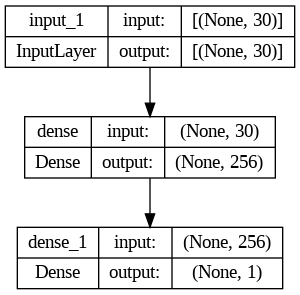

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

## 6. Entrenando el modelo con el argumento `class_weight`

In [ ]:
# https://keras.io/api/metrics/
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics)

callbacks = [keras.callbacks.ModelCheckpoint("checkpoints/fraud_model_at_epoch_{epoch}.keras")]
class_weight = {0: weight_for_0, 1: weight_for_1}

model.fit(
    train_features,
    train_targets,
    batch_size=2048,
    epochs=30,
    verbose=2,
    callbacks=callbacks,
    validation_data=(val_features, val_targets),
    class_weight=class_weight,  # TODO: Comparar modelo sin esta opción
)

Epoch 1/30
112/112 - 5s - loss: 2.5130e-06 - fn: 44.0000 - fp: 22822.0000 - tn: 204607.0000 - tp: 373.0000 - precision: 0.0161 - recall: 0.8945 - val_loss: 0.1421 - val_fn: 9.0000 - val_fp: 1237.0000 - val_tn: 55649.0000 - val_tp: 66.0000 - val_precision: 0.0507 - val_recall: 0.8800 - 5s/epoch - 41ms/step
Epoch 2/30
112/112 - 1s - loss: 1.2518e-06 - fn: 34.0000 - fp: 4357.0000 - tn: 223072.0000 - tp: 383.0000 - precision: 0.0808 - recall: 0.9185 - val_loss: 0.1091 - val_fn: 7.0000 - val_fp: 1146.0000 - val_tn: 55740.0000 - val_tp: 68.0000 - val_precision: 0.0560 - val_recall: 0.9067 - 770ms/epoch - 7ms/step
Epoch 3/30
112/112 - 1s - loss: 1.0709e-06 - fn: 29.0000 - fp: 4610.0000 - tn: 222819.0000 - tp: 388.0000 - precision: 0.0776 - recall: 0.9305 - val_loss: 0.0670 - val_fn: 10.0000 - val_fp: 595.0000 - val_tn: 56291.0000 - val_tp: 65.0000 - val_precision: 0.0985 - val_recall: 0.8667 - 686ms/epoch - 6ms/step
Epoch 4/30
112/112 - 1s - loss: 9.8140e-07 - fn: 27.0000 - fp: 4808.0000 - tn

In [ ]:
val_results = model.evaluate(val_features, val_targets)
# Métricas resultantes
val_results

1781/1781 [==============================] - 5s 3ms/step - loss: 0.0112 - fn: 11.0000 - fp: 174.0000 - tn: 56712.0000 - tp: 64.0000 - precision: 0.2689 - recall: 0.8533


[0.011236146092414856,
 11.0,
 174.0,
 56712.0,
 64.0,
 0.2689075767993927,
 0.8533333539962769]

In [ ]:
# Formato ordenado
pd.DataFrame([val_results], columns=model.metrics_names)

,loss,fn,fp,tn,tp,precision,recall
0,0.011236,11.0,174.0,56712.0,64.0,0.268908,0.853333


En este punto, de las 56.961 transacciones utilizadas en el conjunto de validación, hemos:

* Identificado correctamente a 64 de ellas como fraudulentas
* Fallado en identificar 11 transacciones fraudulentas
* Al costo de marcar incorrectamente 155 transacciones legítimas

En el mundo real, probablamente se le daría más peso a la clase 1, para reflejar que los falsos negativos son más costosos que los falsos positivos.

> Si nuestra tarjeta de crédito es rechazada en una compra online, esta es la razón.

## 7. Serializar y deserializar un modelo en Keras

In [ ]:
OUTPUT_PATH = "model.keras"
model.save(OUTPUT_PATH)

In [ ]:
model_loaded = keras.models.load_model(OUTPUT_PATH)

In [ ]:
# Formato ordenado
pd.DataFrame([model_loaded.evaluate(val_features, val_targets)], columns=model_loaded.metrics_names)

1781/1781 [==============================] - 6s 3ms/step - loss: 0.0112 - fn: 11.0000 - fp: 174.0000 - tn: 56712.0000 - tp: 64.0000 - precision: 0.2689 - recall: 0.8533


,loss,fn,fp,tn,tp,precision,recall
0,0.011236,11.0,174.0,56712.0,64.0,0.268908,0.853333


Estas métricas fueron el resultado del modelo que entrenamos (antes de serializar). Notar que son exactamente iguales a las obtenidas por el modelo que acabamos de deserializar, pues son exactamente el mismo modelo (mismos pesos):

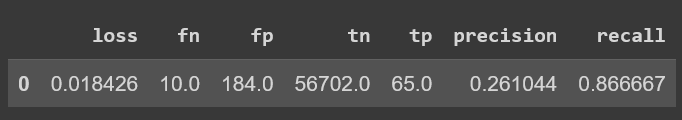